In [1]:
import math
import numpy as np
import warnings
warnings.simplefilter('ignore')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import matplotlib.pyplot as plt

In [2]:
# Parameters
S0 = 36.0 # initial stock value
K = 40.0 # strike price
T = 1.0 # time to maturity
r = 0.06 # risk-less short rate
sigma = 0.20 # volatility of stock value
M = 50 # number of time steps
I = 50000 # number of paths
# Valuation
D = 9 # number of regression functions

In [5]:
def BSM_lsm_put_value(S0, M, I):
    ''' Function to value an American put option by LSM algorithm.

    Parameters
    ==========
    S0: float
        initial index level
    M: int
        number of time steps

    Returns
    =======
    V0: float
        LSM Monte Carlo estimator of American put option value
    S: NumPy array
        simulated index level paths
    ex: NumPy array
        exercise matrix
    rg: NumPy array
        regression coefficients
    h: NumPy array
        inner value matrix
    dt: float
        length of time interval
    '''
    rand = np.random.standard_normal((M + 1, I))  # random numbers
    dt = T / M   # length of time interval
    df = math.exp(-r * dt)  # discount factor
    S = np.zeros((M + 1, I), dtype=np.float64)  # stock price matrix
    S[0] = S0  # initial values
    for t in range(1, M + 1, 1):  # stock price at t
        S[t] = S[t - 1] * (np.exp((r - sigma ** 2 / 2) * dt +
                                  sigma * math.sqrt(dt) * rand[t]))
    h = np.maximum(K - S, 0)  # inner values
    V = np.maximum(K - S, 0)  # value matrix
    ex = np.zeros((M + 1, I), dtype=np.float64)   # exercise matrix
    C = np.zeros((M + 1, I), dtype=np.float64)   # continuation value matrix
    rg = np.zeros((M + 1, D + 1), dtype=np.float64)
    # matrix for reg. coefficients
    for t in range(M - 1, 0, -1):
        rg[t] = np.polyfit(S[t], V[t + 1] * df, D)
        # regression in step i
        C[t] = np.polyval(rg[t], S[t])
        # estimated continuation values
        C[t] = np.where(C[t] < 0, 0., C[t])
        # correction for neg C
        V[t] = np.where(h[t] >= C[t],
                        h[t], V[t + 1] * df)  # exercise decision
        ex[t] = np.where(h[t] >= C[t], 1, 0)
        # exercise decision (yes=1)
    V0 = np.sum(V[1]) / I * df
    return V0, S, ex, rg, h, dt


def BSM_hedge_run(p=0):
    ''' Implements delta hedging for a single path. '''
    np.random.seed(50000)
    #
    # Initial Delta
    #
    ds = 0.01
    V_1, S, ex, rg, h, dt = BSM_lsm_put_value(S0 + ds, M, I)
    V_2 = BSM_lsm_put_value(S0, M, I)[0]
    del_0 = (V_1 - V_2) / ds

    #
    # Dynamic Hedging
    #
    delt = np.zeros(M + 1, dtype=np.float64)  # vector for deltas
    print
    print("APPROXIMATION OF FIRST ORDER ")
    print("-----------------------------")
    print(" %7s | %7s | %7s " % ('step', 'S_t', 'Delta'))
    for t in range(1, M, 1):
        if ex[t, p] == 0:  # if option is alive
            St = S[t, p]  # relevant index level
            diff = (np.polyval(rg[t], St + ds) -
                    np.polyval(rg[t], St))
            # numerator of difference quotient
            delt[t] = diff / ds  # delta as difference quotient
            print(" %7d | %7.2f | %7.2f" % (t, St, delt[t]))
            if (S[t, p] - S[t - 1, p]) * (delt[t] - delt[t - 1]) < 0:
                print("          wrong")
        else:
            break

    delt[0] = del_0
    print()
    print("DYNAMIC HEDGING OF AMERICAN PUT (BSM)")
    print("---------------------------------------")
    po = np.zeros(t, dtype=np.float64)  # vector for portfolio values
    vt = np.zeros(t, dtype=np.float64)  # vector for option values
    vt[0] = V_1
    po[0] = V_1
    bo = V_1 - delt[0] * S0  # bond position value
    print("Initial Hedge")
    print("Stocks             %8.3f" % delt[0])
    print("Bonds              %8.3f" % bo)
    print("Cost               %8.3f" % (delt[0] * S0 + bo))

    print()
    print("Regular Rehedges ")
    print(68 * "-")
    print("step|" + 7 * " %7s|" % ('S_t', 'Port', 'Put',
                                   'Diff', 'Stock', 'Bond', 'Cost'))
    for j in range(1, t, 1):
        vt[j] = BSM_lsm_put_value(S[j, p], M - j, I)[0]
        po[j] = delt[j - 1] * S[j, p] + bo * math.exp(r * dt)
        bo = po[j] - delt[j] * S[j, p]  # bond position value
        print("%4d|" % j + 7 * " %7.3f|" % (S[j, p], po[j], vt[j],
                                            (po[j] - vt[j]), delt[j],
                                            bo, delt[j] * S[j, p] + bo))

    errs = po - vt  # hedge errors
    print("MSE             %7.3f" % (np.sum(errs ** 2) / len(errs)))
    print("Average Error   %7.3f" % (np.sum(errs) / len(errs)))
    print("Total P&L       %7.3f" % np.sum(errs))
    return S[:, p], po, vt, errs, t


def plot_hedge_path(S, po, vt, errs, t):
    #
    # Graphical Output
    #
    tl = np.arange(t)
    plt.figure(figsize=(8, 6))
    plt.subplot(311)
    plt.plot(tl, S[tl], 'r')
    plt.ylabel('index level')
    plt.subplot(312)
    plt.grid(True)
    plt.plot(tl, po[tl], 'r-.', label='portfolio value', lw=2)
    plt.plot(tl, vt[tl], 'b', label='option value', lw=1)
    plt.ylabel('value')
    plt.legend(loc=0)
    ax = plt.axis()
    plt.subplot(313)
    wi = 0.3
    diffs = po[tl] - vt[tl]
    plt.bar(tl - wi / 2, diffs, color='b', width=wi)
    plt.ylabel('difference')
    plt.xlabel('time step')
    plt.axis([ax[0], ax[1], min(diffs) * 1.1, max(diffs) * 1.1])
    plt.tight_layout()

In [6]:
params = BSM_hedge_run(p=0)

APPROXIMATION OF FIRST ORDER 
-----------------------------
    step |     S_t |   Delta 
       1 |   37.31 |   -0.69
          wrong
       2 |   36.01 |   -0.71
       3 |   34.74 |   -0.79

DYNAMIC HEDGING OF AMERICAN PUT (BSM)
---------------------------------------
Initial Hedge
Stocks               -0.995
Bonds                40.303
Cost                  4.474

Regular Rehedges 
--------------------------------------------------------------------
step|     S_t|    Port|     Put|    Diff|   Stock|    Bond|    Cost|
   1|  37.313|   3.215|   3.600|  -0.385|  -0.687|  28.848|   3.215|
   2|  36.013|   4.143|   4.456|  -0.313|  -0.710|  29.700|   4.143|
   3|  34.738|   5.083|   5.415|  -0.332|  -0.791|  32.558|   5.083|
MSE               0.089
Average Error    -0.257
Total P&L        -1.029


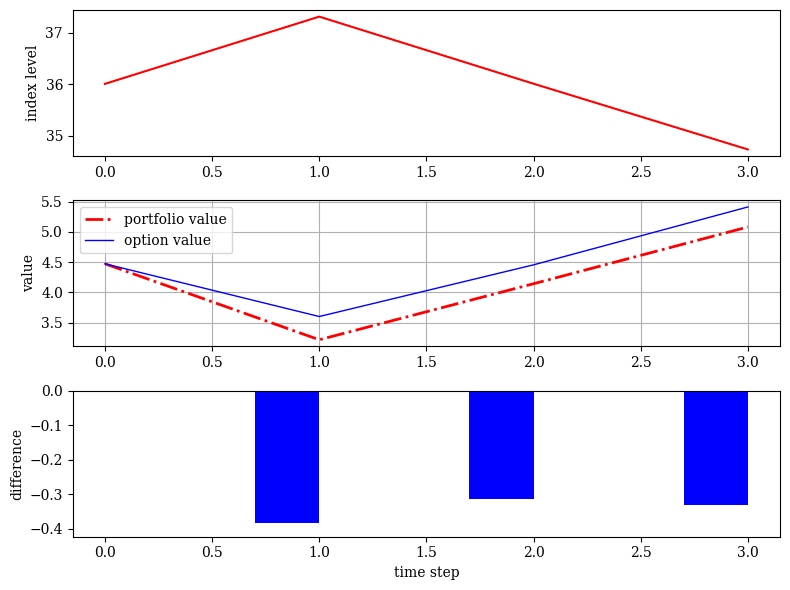

In [7]:
plot_hedge_path(*params)

In [15]:
def BSM_dynamic_hedge_mcs(M=50, I=10000):
    ''' Monte Carlo simualtion of dynamic hedging paths
    for American put option in BSM model. '''
    #
    # Initial Delta
    #
    ds = 0.01
    V_1, S, ex, rg, h, dt = BSM_lsm_put_value(S0 + ds, M, I)
    V_2 = BSM_lsm_put_value(S0, M, I)[0]
    del_0 = (V_1 - V_2) / ds

    print("Value of American Put Option is %8.3f" % V_2)
    print("Delta t=0 is                    %8.3f" % del_0)
    #
    # Dynamic Hedging Runs
    #
    pl_list = []
    run = 0
    runs = min(I, 10000)
    for run in range(runs):
        p = run
        run += 1
        delta = np.zeros(M + 1, dtype=np.float64)  # vector for deltas
        for t in range(0, M, 1):
            if ex[t - 1, p] == 0:  # if option is alive
                St = S[t, p]  # relevant index level
                diff = (np.polyval(rg[t, :], St + ds) -
                        np.polyval(rg[t, :], St))
                # numerator of difference quotient
                delta[t] = diff / ds  # delta as difference quotient
            else:
                break
        delta[0] = del_0
        po = np.zeros(t, dtype=np.float64)  # vector for portfolio values
        vt = np.zeros(t, dtype=np.float64)  # vector for option values
        vt[0] = V_2  # initial option value
        po[0] = V_2  # initial portfolio value
        bo = V_2 - delta[0] * S0  # initial bond position value
        for s in range(1, t, 1):  # for all times up to i-1
            po[s] = delta[s - 1] * S[s, p] + bo * math.exp(r * dt)
            # portfolio payoff
            bo = po[s] - delta[s] * S[s, p]  # bond position value
            if s == t - 1:  # at exercise/expiration date
                vt[s] = h[s, p]  # option value equals inner value
                pl = (po[s] - vt[s]) * math.exp(-r * t * dt)
                # discounted difference between option and portfolio value
                if run % 1000 == 0:
                    print("run %5d   p/l %8.3f" % (run, pl))
                pl_list.append(pl)  # collect all differences
    pl_list = np.array(pl_list)

    #
    # Summary Results Output
    #
    print("\nSUMMARY STATISTICS FOR P&L")
    print("---------------------------------")
    print("Dynamic Replications %12d" % runs)
    print("Time Steps           %12d" % M)
    print("Paths for Valuation  %12d" % I)
    print("Maximum              %12.3f" % max(pl_list))
    print("Average              %12.3f" % np.mean(pl_list))
    print("Median               %12.3f" % np.median(pl_list))
    print("Minimum              %12.3f" % min(pl_list))
    print("---------------------------------")

    return pl_list


def plot_hedge_histogram(pl_list):
    ''' Plot of P/L histogram. '''
    #
    # Graphical Output
    #
    plt.figure(figsize=(8, 6))
    plt.hist(pl_list, 75)
    plt.xlabel('profit/loss')
    plt.ylabel('frequency')

In [11]:
pl_list = BSM_dynamic_hedge_mcs(M=50, I=10000)

Value of American Put Option is    4.482
Delta t=0 is                      -4.358
run  1000   p/l  -10.577
run  2000   p/l    3.172
run  3000   p/l    0.226
run  4000   p/l   -0.112
run  5000   p/l    5.172
run  6000   p/l    3.259
run  7000   p/l    0.763
run  8000   p/l   -0.149
run  9000   p/l    2.695
run 10000   p/l    2.012

SUMMARY STATISTICS FOR P&L
---------------------------------
Dynamic Replications        10000
Time Steps                     50
Paths for Valuation         10000
Maximum                    33.191
Average                    -0.067
Median                      0.047
Minimum                   -15.545
---------------------------------


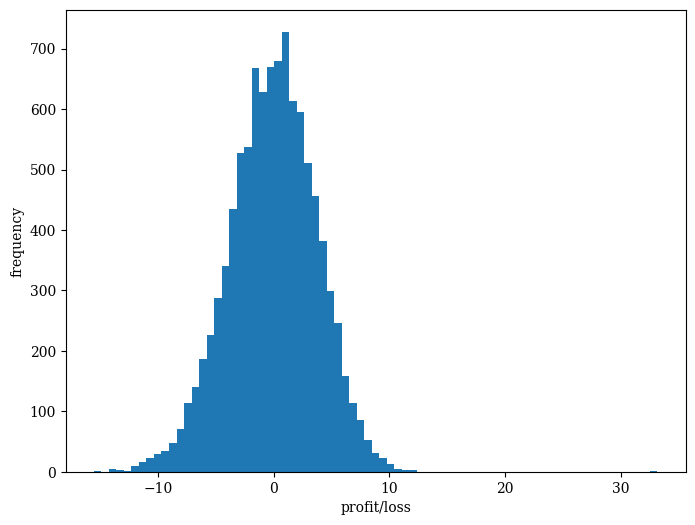

In [16]:
plot_hedge_histogram(pl_list)